**Neural networks for road segmentation**
========================

Your next task is to train neural network to segment road on images from car cams.

The original dataset is provided by Karlsruhe Institute of Technology (http://www.cvlibs.net/datasets/kitti/eval_road.php). Their images are ±370x1270, but, for simlictiy, we will use 370x370 squares.

One can download the dataset from https://disk.yandex.ru/d/QPOw4hk84-se_w

Here is an example of input data with corresponding ground truth:

In [1]:
import os
import cv2
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T

from torchsummary import summary
from torch.utils.data import Dataset
from tqdm.notebook import tqdm as tqdm
from torch.utils.data import Dataset

%matplotlib inline

In [2]:
def get_paths(path):
    _, _, filenames = next(os.walk(path))

    images_paths = []
    for filename in sorted(filenames):            
        images_paths.append(os.path.join(path, filename))
    
    return np.stack(images_paths)

class RoadDataset(Dataset):
    """Feel free to rewrite it. For ex. cache all images in RAM to increase training speed"""
    def __init__(self, images, masks, transform, aug=None,):
        self.images = sorted(images)
        self.masks = sorted(masks)
        self.transform = transform
        self.aug = aug
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):        
        im_name = self.images[idx]
        mask_name = self.masks[idx]
        
        image = cv2.imread(im_name)[:,:,::-1] / 255.0  # ::-1 to convert from BGR to RGB
        mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.float32)
        
        if self.aug:
            sample = self.aug(
                image=image,
                mask=mask,
            )
        else:
            sample = {
                'image': image,
                'mask': mask,
            }
        
        sample['image'] = self.transform(sample['image']).float()
        sample['mask'] = self.transform(sample['mask']).float()

        return sample

In [3]:
X_train = get_paths("./data/train/images")
y_train = get_paths("./data/train/gt")

X_test = get_paths("./data/test/images")
y_test = get_paths("./data/test/gt")

transform = T.Compose([
    T.ToTensor(),
    T.Pad((7, 7, 7, 7))
])

In [4]:
train_dataset = RoadDataset(X_train, y_train, transform)
test_dataset = RoadDataset(X_test, y_test, transform)

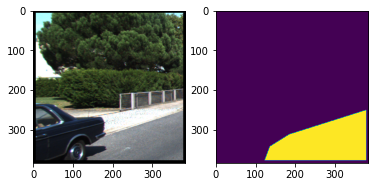

In [5]:
sample = train_dataset[4]
image = sample['image']
mask = sample['mask']

plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask.permute(1, 2, 0))

Workflow:
---
* Choose correct loss function, write training loop and code for testing. Feel free to use previous HW for inspiration. 
* Train any segmentation neural network from scratch (for example U-Net) and achieve >= 0.75 IoU on test set (40% points). See function to calculate the metric below.
* Use any pretrained model for image classification, convert it for segmentation by adding decoder (don't forget skip-connections) or usign dilated convolutions and achieve >= 0.87 IoU  on test set (60% points).

You're not allowed to do only one thing: train your network on test set.

----
Your final solution will consist of an ipython notebook with code (for final networks training + any experiments with data) and test metric calculation.

Feel free to ask in Telegram chat if something is not clear :3


In [6]:
print(f"Dataset length {len(train_dataset)}")

Dataset length 648


Dataset is small so actively use data augmentation: rotations, flip, color-change etc. to prevent overfitting.

Most likely you'll have to pad your images to 512x512 (it divides by 2^5=32, like U-Net wants). Use PadIfNeeded from Albumentations and central crop (see below) after prediction to calculate loss/metrics (you don't want to pay attention on padded values).

----
There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for the "road" class, or add class weights in optimized loss. You also can try to use softIoU or DICE loss.

Good luck!

### Model U-Net

In [7]:
class ConvLayer(nn.Module):
    
    def __init__(self, input_channels, output_channels, padding='same',
                 kernel_size=(3, 3), stride=1, dilation=1, use_dropout=False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=input_channels, 
                               out_channels=output_channels,
                               kernel_size=kernel_size,
                               stride=stride,
                               dilation=dilation,
                               padding=padding)
        self.conv2 = nn.Conv2d(in_channels=output_channels, 
                               out_channels=output_channels,
                               kernel_size=kernel_size,
                               stride=stride,
                               dilation=dilation,
                               padding=padding
                              )
        
        self.dropout2d = nn.Dropout2d(0.2)
        self.use_dropout = use_dropout
        
        self.batchnorm1 = nn.BatchNorm2d(num_features=output_channels)
        self.batchnorm2 = nn.BatchNorm2d(num_features=output_channels)
        
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        
    
    def forward(self, input):
        x = self.conv1(input)
        x = self.relu1(x)
        x = self.batchnorm1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.batchnorm2(x)
        
        if self.use_dropout:
            x = self.dropout2d(x)
        
        return x

In [8]:
class DownScaller(nn.Module):
    
    def __init__(self, input_channels, output_channels, padding='same',
                 kernel_size=(3, 3), stride=1, dilation=1, use_dropout=False):
        super().__init__()
        self.maxpool = nn.MaxPool2d(kernel_size = (2, 2))
        self.conv_layer = ConvLayer(input_channels, output_channels, padding, kernel_size,
                                    stride, dilation, use_dropout)
    
    def forward(self, input):
        x = self.maxpool(input)
        x = self.conv_layer(x)

        return x

In [9]:
class UpScaler(nn.Module):
    
    def __init__(self, input_channels, output_channels,
               kernel_size=(3, 3), stride=1, dilation=1, use_dropout=False):
        super().__init__()
        self.conv_layer = ConvLayer(input_channels, output_channels // 2,
                                    kernel_size=(3, 3), stride=1, dilation=1, use_dropout=use_dropout)
#         self.conv_transposed = nn.ConvTranspose2d(output_channels, output_channels // 2,
#                                           kernel_size=kernel_size, stride=stride)
        self.upscaler = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    
    
    def forward(self, input):
        x = self.conv_layer(input)
        x = self.upscaler(x)
        
        return x
        

In [10]:
class UNet(nn.Module):
    
    def __init__(self):
        super().__init__()
                
        self.input_channel = 3
        self.output_channel = 64
        self.n_classes = 1
        
        # Input
        self.conv1 = ConvLayer(self.input_channel, self.output_channel)
        
        # Downscalling
        self.down1 = DownScaller(self.output_channel, self.output_channel * 2)
        self.down2 = DownScaller(self.output_channel * 2, self.output_channel * 4)
        self.down3 = DownScaller(self.output_channel * 4, self.output_channel * 8, use_dropout=False)
        
        # Bridge
        self.maxpool = nn.MaxPool2d(kernel_size=(2, 2))   
        self.up1 = UpScaler(self.output_channel * 8, self.output_channel * 16)
        
        # Upscalling
        self.up2 = UpScaler(self.output_channel * 16, self.output_channel * 8, use_dropout=False)
        self.up3 = UpScaler(self.output_channel * 8, self.output_channel * 4)
        self.up4 = UpScaler(self.output_channel * 4, self.output_channel * 2)
        
        # Output
        self.conv2 = ConvLayer(self.output_channel * 2, self.output_channel)
        self.conv3 = nn.Conv2d(self.output_channel, self.n_classes, 
                               kernel_size=(3, 3), stride=1, dilation=1, padding='same')
        
    
    def forward(self, input):
               
        x_1 = self.conv1(input)
        x_2 = self.down1(x_1)
        x_3 = self.down2(x_2)
        x_4 = self.down3(x_3)
        
        x_5 = self.maxpool(x_4)
        x_6 = self.up1(x_5)
        
        x_4_skip = torch.cat([x_4, x_6], dim=1)
        x_7 = self.up2(x_4_skip)
        
        x_3_skip = torch.cat([x_3, x_7], dim=1) 
        x_8 = self.up3(x_3_skip)
        
        x_2_skip = torch.cat([x_2, x_8], dim=1)
        x_9 = self.up4(x_2_skip)
        
        x_1_skip = torch.cat([x_1, x_9], dim=1) 
        x_10 = self.conv2(x_1_skip)
        
        output = self.conv3(x_10)
        
        return output
    
    def center_crop(self, source_tensor, target_tensor):
        print(source_tensor.shape, target_tensor.shape)
        (_, _, h, w) = target_tensor.shape
        crop = T.CenterCrop((h, w))(source_tensor)
        crop_concat = torch.cat([crop, target_tensor], dim=1)
        
        return crop_concat
        

In [11]:
# CHECK
unet = UNet()
a = torch.rand([4, 3, 384, 384])
out = unet(a)

print(out.shape)

torch.Size([4, 1, 384, 384])


### Train U-Net

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet().to(device)
summary(model, input_size=train_dataset[0]['image'].shape)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 384, 384]           1,792
              ReLU-2         [-1, 64, 384, 384]               0
       BatchNorm2d-3         [-1, 64, 384, 384]             128
            Conv2d-4         [-1, 64, 384, 384]          36,928
              ReLU-5         [-1, 64, 384, 384]               0
       BatchNorm2d-6         [-1, 64, 384, 384]             128
         ConvLayer-7         [-1, 64, 384, 384]               0
         MaxPool2d-8         [-1, 64, 192, 192]               0
            Conv2d-9        [-1, 128, 192, 192]          73,856
             ReLU-10        [-1, 128, 192, 192]               0
      BatchNorm2d-11        [-1, 128, 192, 192]             256
           Conv2d-12        [-1, 128, 192, 192]         147,584
             ReLU-13        [-1, 128, 192, 192]               0
      BatchNorm2d-14        [-1, 128, 1

In [13]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / (union + 1e-10)


def calc_dice(pred, target, alpha = 1.):
    pred = pred.view(-1).contiguous()
    target = target.view(-1).contiguous()

    intersection = (pred * target).sum()                            
    dice = (2 * intersection + alpha) / (pred.sum() + target.sum() + alpha) 
    
    return dice


def calc_loss(pred, target):
#     weights = torch.eye(target.shape[0]) * 1 + 1
    
    bce_loss = F.binary_cross_entropy_with_logits(pred, target, 
#                                                   weight=weights.to(device)
                                                 )
    dice_loss = 1 - calc_dice(pred, target)
    
#     loss = bce_loss + dice_loss
    
    return dice_loss

In [14]:
def train_model(model, data_loader, optimizer):
    loss_history = []
    iou_history = []
    
    for i, batch in enumerate(tqdm(data_loader), 1):
        x_batch, y_batch = batch['image'].to(device), batch['mask'].to(device)
        
        optimizer.zero_grad()
        
        output = model(x_batch)
        loss = calc_loss(output, y_batch)
        loss.backward()
           
        optimizer.step()
        
        loss_history.append(loss.item())
        iou_history.append(calc_iou(output.cpu().detach().numpy(), 
                                    y_batch.cpu().detach().numpy()))
#         if i % 50 == 0:
#             print(loss_history[-1], iou_history[-1])
    print(f'Loss: {np.mean(loss_history):.3f} ± {np.std(loss_history):.3f}\
            IoU: {np.mean(iou_history):.3f}  ± {np.std(iou_history):.3f}')
    
    return model

In [15]:
@torch.no_grad()
def eval_model(model, data_loader):
    loss_history = []
    iou_history = []
    
    for i, batch in enumerate(data_loader, 1):
        x_batch, y_batch = batch['image'].to(device), batch['mask'].to(device)
        
        output = model(x_batch)
        loss = calc_loss(output, y_batch)
        
        loss_history.append(loss.item())
        iou_history.append(calc_iou(output.cpu().detach().numpy(), 
                                    y_batch.cpu().detach().numpy()))
        
#         if i % 50 == 0:
#             print(loss_history[-1], iou_history[-1])

    print(f'Loss: {np.mean(loss_history):.3f} ± {np.std(loss_history):.3f}\
            IoU: {np.mean(iou_history):.3f}  ± {np.std(iou_history):.3f}\n')
    
    image = train_dataset[0]['image'].to(device)
    pred_mask = model(image[None, :, :, :])
    plt.subplot(1, 2, 1)
    plt.imshow(image.cpu().permute(1, 2, 0))
    plt.subplot(1, 2, 2)
    plt.imshow(pred_mask.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
    plt.show()

In [16]:
BATCH_SIZE = 1
EPOCHS = 20
learning_rate = 0.01

In [17]:
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE,
                                           num_workers=12)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE, 
                                          num_workers=12)

In [ ]:
# 1) albumentation
# 2) batch size = 2
# 3) change arch
# 4) scale to 512x512

EPOCH:   0%|          | 0/20 [00:00<?, ?it/s]

-------------------------------------------------- Epoch 1 / 20 --------------------------------------------------
LR = [0.01]
TRAIN


  0%|          | 0/648 [00:00<?, ?it/s]

Loss: -3.074 ± 15.258            IoU: 0.166  ± 0.251
VALID
Loss: -0.532 ± 6.851            IoU: 0.029  ± 0.058



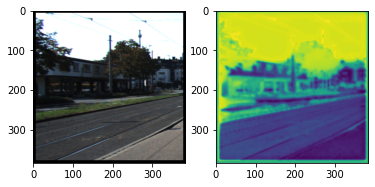

-------------------------------------------------- Epoch 2 / 20 --------------------------------------------------
LR = [0.01]
TRAIN


  0%|          | 0/648 [00:00<?, ?it/s]

Loss: -5.290 ± 10.828            IoU: 0.348  ± 0.335
VALID
Loss: -18.920 ± 293.377            IoU: 0.465  ± 0.321



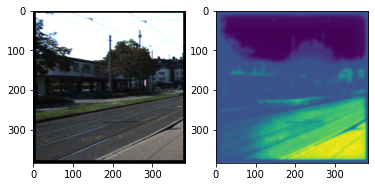

-------------------------------------------------- Epoch 3 / 20 --------------------------------------------------
LR = [0.01]
TRAIN


  0%|          | 0/648 [00:00<?, ?it/s]

Loss: -9.071 ± 18.807            IoU: 0.146  ± 0.264
VALID
Loss: -1.343 ± 14.698            IoU: 0.032  ± 0.047



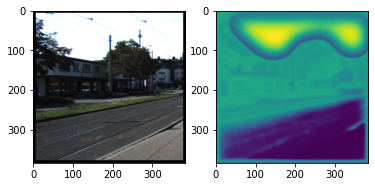

-------------------------------------------------- Epoch 4 / 20 --------------------------------------------------
LR = [0.01]
TRAIN


  0%|          | 0/648 [00:00<?, ?it/s]

Loss: -14.318 ± 66.425            IoU: 0.183  ± 0.257
VALID
Loss: 0.121 ± 11.783            IoU: 0.010  ± 0.024



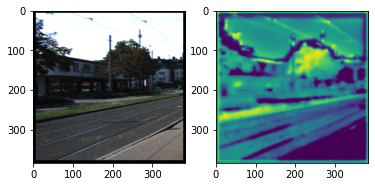

-------------------------------------------------- Epoch 5 / 20 --------------------------------------------------
LR = [0.005]
TRAIN


  0%|          | 0/648 [00:00<?, ?it/s]

Loss: -8.460 ± 7.152            IoU: 0.016  ± 0.025
VALID
Loss: 0.481 ± 21.400            IoU: 0.022  ± 0.033



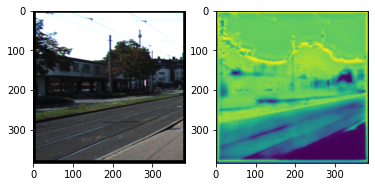

-------------------------------------------------- Epoch 6 / 20 --------------------------------------------------
LR = [0.005]
TRAIN


  0%|          | 0/648 [00:00<?, ?it/s]

Loss: -14.477 ± 10.485            IoU: 0.022  ± 0.024
VALID
Loss: 9.044 ± 88.190            IoU: 0.033  ± 0.046



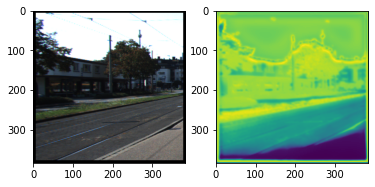

-------------------------------------------------- Epoch 7 / 20 --------------------------------------------------
LR = [0.005]
TRAIN


  0%|          | 0/648 [00:00<?, ?it/s]

Loss: -12.973 ± 38.684            IoU: 0.264  ± 0.250
VALID
Loss: 11.179 ± 235.949            IoU: 0.383  ± 0.289



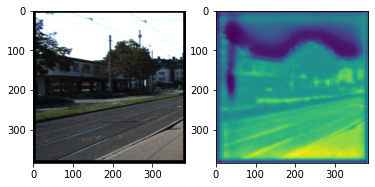

-------------------------------------------------- Epoch 8 / 20 --------------------------------------------------
LR = [0.005]
TRAIN


  0%|          | 0/648 [00:00<?, ?it/s]

Loss: -21.714 ± 49.887            IoU: 0.243  ± 0.267
VALID
Loss: 7.514 ± 62.884            IoU: 0.377  ± 0.276



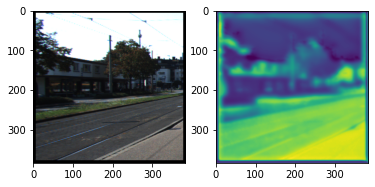

-------------------------------------------------- Epoch 9 / 20 --------------------------------------------------
LR = [0.0025]
TRAIN


  0%|          | 0/648 [00:00<?, ?it/s]

Loss: -31.313 ± 52.106            IoU: 0.379  ± 0.299
VALID
Loss: 0.753 ± 0.337            IoU: 0.188  ± 0.155



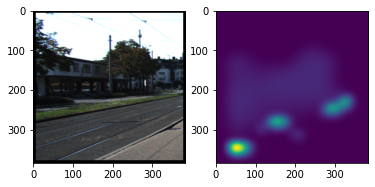

-------------------------------------------------- Epoch 10 / 20 --------------------------------------------------
LR = [0.0025]
TRAIN


  0%|          | 0/648 [00:00<?, ?it/s]

Loss: -29.802 ± 55.452            IoU: 0.252  ± 0.256
VALID
Loss: 0.773 ± 27.018            IoU: 0.423  ± 0.291



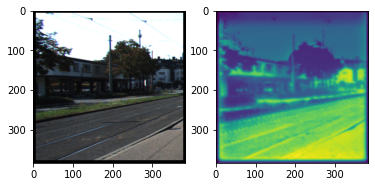

-------------------------------------------------- Epoch 11 / 20 --------------------------------------------------
LR = [0.0025]
TRAIN


  0%|          | 0/648 [00:00<?, ?it/s]

Loss: -33.739 ± 147.748            IoU: 0.117  ± 0.228
VALID
Loss: 2.131 ± 11.369            IoU: 0.036  ± 0.059



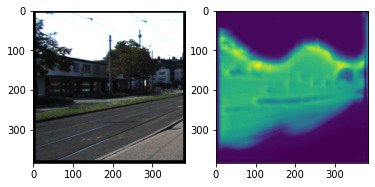

-------------------------------------------------- Epoch 12 / 20 --------------------------------------------------
LR = [0.0025]
TRAIN


  0%|          | 0/648 [00:00<?, ?it/s]

Loss: -44.395 ± 36.381            IoU: 0.027  ± 0.036
VALID
Loss: 0.695 ± 0.298            IoU: 0.210  ± 0.163



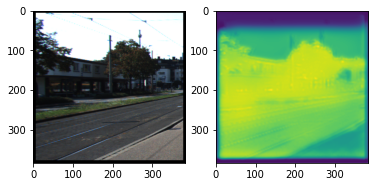

-------------------------------------------------- Epoch 13 / 20 --------------------------------------------------
LR = [0.00125]
TRAIN


  0%|          | 0/648 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [18]:
torch.cuda.empty_cache()

model = UNet().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

for epoch in tqdm(range(EPOCHS), desc='EPOCH'):
    print('-' * 50, f'Epoch {epoch + 1} / {EPOCHS}', '-' * 50)
    print(f'LR = {scheduler.get_last_lr()}')
    
    print('TRAIN')
    model.train(True) 
    model = train_model(model, train_loader, optimizer)
    
    print('VALID')
    model.train(False) 
    eval_model(model, test_loader)
    
    scheduler.step()
    